In [2]:
# use ?fo=json to get metadata of the item

In [4]:
import io
import pandas as pd                     # for reading, manipulating, and displaying data
import requests
from helpers_loc import get_file_stats
# jukebox dataset
DATA_URL = 'https://data.labs.loc.gov/jukebox/' # Base URL of this data package
# Download the file manifest
file_manifest_url = f'{DATA_URL}manifest.json'
response = requests.get(file_manifest_url, timeout=60)
response_json = response.json()
# file information json
files = [dict(zip(response_json["cols"], row)) for row in response_json["rows"]] # zip columns and rows

# Convert to Pandas DataFrame and show stats table
stats = get_file_stats(files)

In [5]:
df = pd.DataFrame(stats)
df

,FileType,Count,Size
0,.mp3,"5,882",17.0GB


In [6]:
metadata_url = f'{DATA_URL}metadata.json'
response = requests.get(metadata_url, timeout=60)
data = response.json()
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 5,882 entries.


In [7]:
df_metadata = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

FileType, Count, Size


In [8]:
df_metadata.head()

,Date,Description,Digitized,Id,IIIF_manifest,Preview_url,Audio_type,Contributors,Genre,Language,...,Repository,Number_of_files,Shelf_id,Subjects,Last_updated_in_api,Title,Type_of_resource,Url,Source_collection,Location
0,1917-01-25,"[Victor 10000. Matrix/Take: C-19133/2., Vocal ...",True,http://www.loc.gov/item/jukebox-21582/,http://www.loc.gov/item/jukebox-21582/manifest...,[],Vocal,"[{'Name': 'Egener, Minnie', 'Role': 'Vocalist ...","[Classical music, Opera]",[Italian],...,"[Recorded Sound Section, Library Of Congress]",1,Victor 10000,"[Classical music, Vocal, Opera, Victor]",2023-01-18T19:13:06.977Z,Sextet (Chi mi frena),Audio,https://www.loc.gov/item/jukebox-21582/,National Jukebox,"[{'Short_name': 'Camden', 'Full_name': 'Camden..."
1,1908-02-07,"[Vocal sextet (soprano, mezzo-soprano, 2 tenor...",True,http://www.loc.gov/item/jukebox-125974/,http://www.loc.gov/item/jukebox-125974/manifes...,[],Vocal,"[{'Name': 'Daddi, Francesco', 'Role': 'Vocalis...",[Opera],[Italian],...,"[Recorded Sound Section, Library Of Congress]",1,Victor 10001,"[Vocal, Opera, Victor]",2023-01-18T19:11:17.489Z,Sextette : Chi mi frena,Audio,https://www.loc.gov/item/jukebox-125974/,National Jukebox,"[{'Short_name': 'New York', 'Full_name': 'New ..."
2,1912-01-07,"[Victor 10002. Matrix/Take: C-11438/1., Vocal ...",True,http://www.loc.gov/item/jukebox-131319/,http://www.loc.gov/item/jukebox-131319/manifes...,[],Vocal,"[{'Name': 'Caruso, Enrico', 'Role': 'Vocalist ...","[Classical music, Opera]",[Italian],...,"[Recorded Sound Section, Library Of Congress]",1,Victor 10002,"[Classical music, Vocal, Opera, Victor]",2023-01-18T19:11:49.253Z,Che vuol dir cio,Audio,https://www.loc.gov/item/jukebox-131319/,National Jukebox,"[{'Short_name': 'New York', 'Full_name': 'New ..."
3,1910-01-12,"[Victor 10004. Matrix/Take: C-8544/1., Vocal q...",True,http://www.loc.gov/item/jukebox-128347/,http://www.loc.gov/item/jukebox-128347/manifes...,[],Vocal,"[{'Name': 'Farrar, Geraldine', 'Role': 'Vocali...","[Classical music, Opera]",[French],...,"[Recorded Sound Section, Library Of Congress]",1,Victor 10004,"[Classical music, Vocal, Opera, Victor]",2023-01-18T19:11:30.026Z,Seigneur Dieu!,Audio,https://www.loc.gov/item/jukebox-128347/,National Jukebox,"[{'Short_name': 'New York', 'Full_name': 'New ..."
4,1910-01-12,"[Vocal quartet (soprano, mezzo-soprano, tenor,...",True,http://www.loc.gov/item/jukebox-128360/,http://www.loc.gov/item/jukebox-128360/manifes...,[],Vocal,"[{'Name': 'Farrar, Geraldine', 'Role': 'Vocali...","[Classical music, Opera]",[French],...,"[Recorded Sound Section, Library Of Congress]",1,Victor 10004,"[Classical music, Vocal, Opera, Victor]",2023-01-18T19:11:30.026Z,"Eh quoi, toujours seule",Audio,https://www.loc.gov/item/jukebox-128360/,National Jukebox,"[{'Short_name': 'New York', 'Full_name': 'New ..."


In [9]:
df_metadata_by_subject = df_metadata.explode('Subjects')
df_opera = df_metadata_by_subject[df_metadata_by_subject.Subjects == 'Opera']
print(f'Found {df_opera.shape[0]:,} items with subject "Opera"')

Found 933 items with subject "Opera"


In [10]:
# create a DataFrame from the file information
df_files = pd.DataFrame(files)
# join the metadata dataframe with the file information dataframe
opera_set_with_audio = pd.merge(df_opera, df_files, left_on='Id', right_on='item_id', how='inner')
print(f'Found {opera_set_with_audio.shape[0]:,} opera items with audio files')

Found 933 opera items with audio files


In [11]:
opera_set_with_audio.head()

,Date,Description,Digitized,Id,IIIF_manifest,Preview_url,Audio_type,Contributors,Genre,Language,...,Title,Type_of_resource,Url,Source_collection,Location,filename,item_id,md5,size,object_key
0,1917-01-25,"[Victor 10000. Matrix/Take: C-19133/2., Vocal ...",True,http://www.loc.gov/item/jukebox-21582/,http://www.loc.gov/item/jukebox-21582/manifest...,[],Vocal,"[{'Name': 'Egener, Minnie', 'Role': 'Vocalist ...","[Classical music, Opera]",[Italian],...,Sextet (Chi mi frena),Audio,https://www.loc.gov/item/jukebox-21582/,National Jukebox,"[{'Short_name': 'Camden', 'Full_name': 'Camden...",jukebox-21582_1.mp3,http://www.loc.gov/item/jukebox-21582/,88339e787c3638cea7021ba4829da919,3753718,data.labs.loc.gov/jukebox/audio/jukebox-21582_...
1,1908-02-07,"[Vocal sextet (soprano, mezzo-soprano, 2 tenor...",True,http://www.loc.gov/item/jukebox-125974/,http://www.loc.gov/item/jukebox-125974/manifes...,[],Vocal,"[{'Name': 'Daddi, Francesco', 'Role': 'Vocalis...",[Opera],[Italian],...,Sextette : Chi mi frena,Audio,https://www.loc.gov/item/jukebox-125974/,National Jukebox,"[{'Short_name': 'New York', 'Full_name': 'New ...",jukebox-125974_1.mp3,http://www.loc.gov/item/jukebox-125974/,57709719e7b2bc105223ba72234d1fbb,3869074,data.labs.loc.gov/jukebox/audio/jukebox-125974...
2,1912-01-07,"[Victor 10002. Matrix/Take: C-11438/1., Vocal ...",True,http://www.loc.gov/item/jukebox-131319/,http://www.loc.gov/item/jukebox-131319/manifes...,[],Vocal,"[{'Name': 'Caruso, Enrico', 'Role': 'Vocalist ...","[Classical music, Opera]",[Italian],...,Che vuol dir cio,Audio,https://www.loc.gov/item/jukebox-131319/,National Jukebox,"[{'Short_name': 'New York', 'Full_name': 'New ...",jukebox-131319_1.mp3,http://www.loc.gov/item/jukebox-131319/,4f0dcccc96217f7ab3c905b2060a9558,3461982,data.labs.loc.gov/jukebox/audio/jukebox-131319...
3,1910-01-12,"[Victor 10004. Matrix/Take: C-8544/1., Vocal q...",True,http://www.loc.gov/item/jukebox-128347/,http://www.loc.gov/item/jukebox-128347/manifes...,[],Vocal,"[{'Name': 'Farrar, Geraldine', 'Role': 'Vocali...","[Classical music, Opera]",[French],...,Seigneur Dieu!,Audio,https://www.loc.gov/item/jukebox-128347/,National Jukebox,"[{'Short_name': 'New York', 'Full_name': 'New ...",jukebox-128347_1.mp3,http://www.loc.gov/item/jukebox-128347/,7e8f547925d1bb186cb87113d85d4174,4263209,data.labs.loc.gov/jukebox/audio/jukebox-128347...
4,1910-01-12,"[Vocal quartet (soprano, mezzo-soprano, tenor,...",True,http://www.loc.gov/item/jukebox-128360/,http://www.loc.gov/item/jukebox-128360/manifes...,[],Vocal,"[{'Name': 'Farrar, Geraldine', 'Role': 'Vocali...","[Classical music, Opera]",[French],...,"Eh quoi, toujours seule",Audio,https://www.loc.gov/item/jukebox-128360/,National Jukebox,"[{'Short_name': 'New York', 'Full_name': 'New ...",jukebox-128360_1.mp3,http://www.loc.gov/item/jukebox-128360/,bec066f7ab6f06d6a1040718097dd7ed,3806380,data.labs.loc.gov/jukebox/audio/jukebox-128360...


In [9]:
# object_key contains the path to the audio file
import io

import matplotlib.pyplot as plt         # for displaying data
import numpy as np
from pydub import AudioSegment          # for reading and manipulating audio files
from scipy import signal                # for visualizing audio

item = opera_set_with_audio.iloc[0]
file_url = f'https://{item["object_key"]}'

/Users/ac/main/amia2025-stt-benchmarking/.venv/lib/python3.12/site-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/Users/ac/main/amia2025-stt-benchmarking/.venv/lib/python3.12/site-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/Users/ac/main/amia2025-stt-benchmarking/.venv/lib/python3.12/site-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/Users/ac/main/amia2025-stt-benchmarking/.venv/lib/python3.12/site-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


In [ ]:
# Download the audio to memory
response = requests.get(file_url, timeout=60)
audio_filestream = io.BytesIO(response.content)

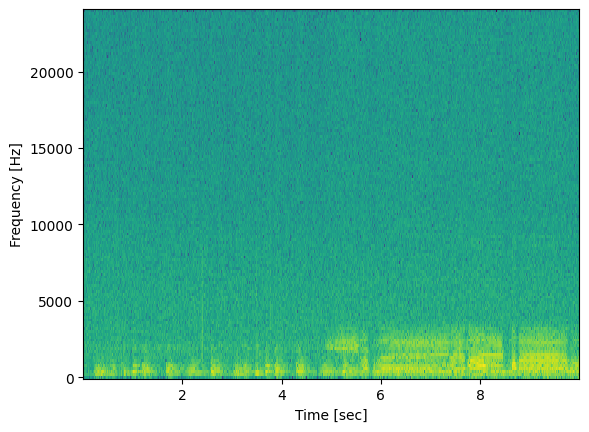

In [11]:
# Read as mp3
sample_rate = 48000
sample_width = 1
channels = 1
audio_filestream.seek(0)  # Ensure stream is at the beginning
sound = AudioSegment.from_mp3(audio_filestream)
sound = sound.set_channels(channels)
sound = sound.set_sample_width(sample_width)
sound = sound.set_frame_rate(sample_rate)

# Get the first 10 seconds
ten_seconds = 10 * 1000
first_10_seconds = sound[:ten_seconds]

# Get audio samples and sample rate
samples = first_10_seconds.get_array_of_samples()
samples = np.array(samples)

# Visualize the results
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
plt.pcolormesh(times, frequencies, np.log(spectrogram))
# plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [13]:
# veterans history project dataset
DATA_URL = 'https://www.loc.gov/collections/veterans-history-project-collection'
DATA_URL = "https://www.loc.gov/collections/veterans-history-project-collection/?fa=online-format:online+text"
# adding fo=json can return web representation: https://www.loc.gov/collections/veterans-history-project-collection?fo=json
# example code to parse the returned JSON
web_rep_url = f'{DATA_URL}?fo=json'
web_rep_url = "https://www.loc.gov/collections/veterans-history-project-collection/?fo=json&fa=online-format:online+text"
# web_rep_url = "https://www.loc.gov/search/?q=baseball&fo=json"
# Start with the initial URL
current_url = web_rep_url
# Initialize an empty list to store all results
all_results = []
import time
import requests
# import error type
from requests.exceptions import RequestException
# chucked encoding error
from requests.exceptions import ChunkedEncodingError

In [14]:
# Constants for rate limiting and paging
RATE_LIMIT_DELAY = 3  # Delay in seconds between requests (20 requests per minute)
MAX_ITEMS_PER_PAGE = 1000  # Recommended maximum items per page
MAX_TOTAL_ITEMS = 10  # Maximum items per query !! Set low for testing !!
RETRY_DELAY = 1  # Initial delay in seconds for retries
MAX_RETRIES = 5  # Maximum number of retries for rate-limited requests

In [15]:
# Retry logic with exponential backoff for 429 status codes
def fetch_url_with_rate_limit(url, timeout=60):
    retries = 0
    while retries < MAX_RETRIES:
        try:
            print(f"Attempting to fetch URL: {url}")
            response = requests.get(url, timeout=timeout)
            if response.status_code == 429:  # Too Many Requests
                print("Rate limit exceeded. Pausing...")
                time.sleep(RETRY_DELAY * (2 ** retries))  # Exponential backoff
                retries += 1
                continue
            response.raise_for_status()  # Raise HTTPError for bad responses
            return response
        except requests.exceptions.RequestException as req_err:
            print(f"Request error occurred: {req_err}")
            retries += 1
            time.sleep(RETRY_DELAY * (2 ** retries))  # Exponential backoff
    raise Exception(f"Failed to fetch {url} after {MAX_RETRIES} retries.")

# Loop through pages with rate limiting and paging limits
total_items_processed = 0
while current_url and total_items_processed < MAX_TOTAL_ITEMS:
    try:
        response = fetch_url_with_rate_limit(current_url)
        data = response.json()

        # Process the results on the current page
        results = data.get('results', [])
        all_results.extend(results)
        total_items_processed += len(results)
        print(f"Processed {len(results)} results. Total: {total_items_processed}")

        # Get the URL for the next page
        current_url = data.get('pagination', {}).get('next')
        print(f"Next page URL: {current_url}")

        # Delay to respect rate limits
        time.sleep(RATE_LIMIT_DELAY)
    except Exception as e:
        print(f"Error processing page {current_url}: {e}")
        break

# Convert the accumulated results into a DataFrame
if all_results:
    df_results = pd.DataFrame(all_results)
    print("DataFrame created successfully.")
else:
    print("No results found.")


Attempting to fetch URL: https://www.loc.gov/collections/veterans-history-project-collection/?fo=json&fa=online-format:online+text
Processed 25 results. Total: 25
Next page URL: https://www.loc.gov/collections/veterans-history-project-collection/?fa=online-format:online+text&fo=json&sp=2
DataFrame created successfully.


In [16]:
df_results.head()

,access_restricted,aka,campaigns,contributor,contributor_interviewer,contributor_organization,contributor_veteran,date,dates,description,...,subject_rank,subject_status,subject_unit,timestamp,title,url,subject_race,number_pow,segments,partof_serving_our_voices
0,False,"[http://www.loc.gov/item/afc2001001.44003/, fi...",[],"[american legion auxiliary unit, fertile, minn...","[larson, carole]","[american legion auxiliary unit, fertile, minn...","[aanden, thorvald]",1942,[[1942 TO 1945]],"[Private First Class, Army, World War, 1939-19...",...,"[private first class, veteran]",[veteran],"[47th armored infantry battalion, combat comma...",2025-10-19T01:16:28.041Z,Thorvald Aanden Collection,https://www.loc.gov/item/afc2001001.44003/,NaN,NaN,NaN,NaN
1,False,"[http://www.loc.gov/item/afc2001001.51925/, fi...",[],"[lugar, richard, u.s. senate/richard lugar, aa...","[thomas, henrietta marie]",[u.s. senate/richard lugar],"[aaron jr., john]",1957,"[1957, [1941 TO 1945]]","[Major, Army, Vietnam War, 1961-1975 - Fort Be...",...,"[major, veteran]",[veteran],"[7th naval beach battalion, navy reserve]",2025-10-19T01:59:10.787Z,"John Aaron, Jr. Collection",https://www.loc.gov/item/afc2001001.51925/,[black or african american],NaN,NaN,NaN
2,False,"[http://www.loc.gov/item/afc2001001.32482/, fi...",[],"[weinstock, alex, veterans history project clu...","[weinstock, alex]","[veterans history project club, staples high s...","[aarons, ronald d.]",1961,[[1961 TO 1983]],"[Major, Air Force, Vietnam War, 1961-1975 - Te...",...,"[major, veteran]",[veteran],[air force audit agency],2025-10-19T02:02:47.451Z,Ronald D. Aarons Collection,https://www.loc.gov/item/afc2001001.32482/,NaN,NaN,NaN,NaN
3,False,"[http://www.loc.gov/item/afc2001001.41825/, fi...",[],"[wiens, brenton jerome, abbott, loyd ernest]","[wiens, brenton jerome]",NaN,"[abbott, loyd ernest]",1954,"[[1954 TO 1957], [1959 TO 1976]]","[Navy, Cold War - San Diego, California; Termi...",...,"[veteran, master sergeant]",[veteran],NaN,2025-10-19T01:04:56.772Z,Loyd Ernest Abbott Collection,https://www.loc.gov/item/afc2001001.41825/,NaN,NaN,NaN,NaN
4,False,"[http://www.loc.gov/item/afc2001001.111208/, f...",[],"[national court reporters association (ncra), ...","[sbertoli, thomas l.]",[national court reporters association (ncra)],"[abboud, alfred robert]",1951,[[1951 TO 1960]],"[Captain, Marine Corps, Korean War, 1950-1953 ...",...,"[captain, veteran]",[veteran],"[b company, 1st battalion, 5th marine regiment...",2025-10-19T02:11:25.799Z,Alfred Robert Abboud Collection,https://www.loc.gov/item/afc2001001.111208/,NaN,NaN,NaN,NaN


In [17]:
# save df as parquet file
df_results.to_parquet('veterans_history_project.parquet', index=False)

In [18]:
print(f'Loaded web representation with {len(data):,} entries.')

Loaded web representation with 31 entries.


In [19]:
# retrieve the df_results DataFrame from the parquet file
df_results = pd.read_parquet('veterans_history_project.parquet')

In [20]:
df_results.head()

,access_restricted,aka,campaigns,contributor,contributor_interviewer,contributor_organization,contributor_veteran,date,dates,description,...,subject_rank,subject_status,subject_unit,timestamp,title,url,subject_race,number_pow,segments,partof_serving_our_voices
0,False,"[http://www.loc.gov/item/afc2001001.44003/, fi...",[],"[american legion auxiliary unit, fertile, minn...","[larson, carole]","[american legion auxiliary unit, fertile, minn...","[aanden, thorvald]",1942,[[1942 TO 1945]],"[Private First Class, Army, World War, 1939-19...",...,"[private first class, veteran]",[veteran],"[47th armored infantry battalion, combat comma...",2025-10-19T01:16:28.041Z,Thorvald Aanden Collection,https://www.loc.gov/item/afc2001001.44003/,None,None,None,None
1,False,"[http://www.loc.gov/item/afc2001001.51925/, fi...",[],"[lugar, richard, u.s. senate/richard lugar, aa...","[thomas, henrietta marie]",[u.s. senate/richard lugar],"[aaron jr., john]",1957,"[1957, [1941 TO 1945]]","[Major, Army, Vietnam War, 1961-1975 - Fort Be...",...,"[major, veteran]",[veteran],"[7th naval beach battalion, navy reserve]",2025-10-19T01:59:10.787Z,"John Aaron, Jr. Collection",https://www.loc.gov/item/afc2001001.51925/,[black or african american],None,None,None
2,False,"[http://www.loc.gov/item/afc2001001.32482/, fi...",[],"[weinstock, alex, veterans history project clu...","[weinstock, alex]","[veterans history project club, staples high s...","[aarons, ronald d.]",1961,[[1961 TO 1983]],"[Major, Air Force, Vietnam War, 1961-1975 - Te...",...,"[major, veteran]",[veteran],[air force audit agency],2025-10-19T02:02:47.451Z,Ronald D. Aarons Collection,https://www.loc.gov/item/afc2001001.32482/,None,None,None,None
3,False,"[http://www.loc.gov/item/afc2001001.41825/, fi...",[],"[wiens, brenton jerome, abbott, loyd ernest]","[wiens, brenton jerome]",None,"[abbott, loyd ernest]",1954,"[[1954 TO 1957], [1959 TO 1976]]","[Navy, Cold War - San Diego, California; Termi...",...,"[veteran, master sergeant]",[veteran],None,2025-10-19T01:04:56.772Z,Loyd Ernest Abbott Collection,https://www.loc.gov/item/afc2001001.41825/,None,None,None,None
4,False,"[http://www.loc.gov/item/afc2001001.111208/, f...",[],"[national court reporters association (ncra), ...","[sbertoli, thomas l.]",[national court reporters association (ncra)],"[abboud, alfred robert]",1951,[[1951 TO 1960]],"[Captain, Marine Corps, Korean War, 1950-1953 ...",...,"[captain, veteran]",[veteran],"[b company, 1st battalion, 5th marine regiment...",2025-10-19T02:11:25.799Z,Alfred Robert Abboud Collection,https://www.loc.gov/item/afc2001001.111208/,None,None,None,None


In [21]:
df_results.columns
# for each column print the first row data
for col in df_results.columns:
    print(f'{col}: {df_results[col].iloc[0]}')

access_restricted: False
aka: ['http://www.loc.gov/item/afc2001001.44003/'
 'file:///natlib/afc2001001/registry/mets/08/loc.natlib.afc2001001.44003.xml'
 'https://tile.loc.gov/storage-services/natlib/afc2001001/vhp-stories/mets/loc.natlib.afc2001001.44003.xml'
 'http://www.loc.gov/resource/afc2001001.44003.mv0001001/']
campaigns: []
contributor: ['american legion auxiliary unit, fertile, minnesota' 'larson, carole'
 'aanden, thorvald']
contributor_interviewer: ['larson, carole']
contributor_organization: ['american legion auxiliary unit, fertile, minnesota']
contributor_veteran: ['aanden, thorvald']
date: 1942
dates: ['[1942 TO 1945]']
description: ['Private First Class, Army, World War, 1939-1945 - England; Normandy, France; Le Mans, France; Germany.']
digitized: True
extract_timestamp: 2025-10-18T18:51:38.401Z
group: ['veterans-mets-02' 'veterans-mets']
hassegments: False
id: http://www.loc.gov/item/afc2001001.44003/
image_url: ['https://tile.loc.gov/streaming-services/iiif/service:v

In [22]:
l_resource = []
# for n in range(len(df_results)):
for n in range(10):
    collection_number = df_results['item'][n]['collection_number']
    title = df_results['title'][n]
    description = df_results['description'][n]
    dates = df_results['dates'][n]
    language = df_results['language'][n]
    location = df_results['location'][n]
    location_home = df_results['location_home'][n]
    location_service = df_results['location_service'][n]
    partof = df_results['partof'][n]
    subject = df_results['subject'][n]
    subject_battles = df_results['subject_battles'][n]
    subject_branch = df_results['subject_branch'][n]
    subject_conflict = df_results['subject_conflict'][n]
    subject_entrance = df_results['subject_entrance'][n]
    subject_format = df_results['subject_format'][n]
    subject_gender = df_results['subject_gender'][n]
    subject_rank = df_results['subject_rank'][n]
    subject_status = df_results['subject_status'][n]
    subject_unit = df_results['subject_unit'][n]
    subject_race = df_results['subject_race'][n]
    collection_resource = []

    for resource in df_results['resources'][n]:
        try:
            fulltext_file_url = resource.get('fulltext_file', None)
            retries = 0
            while retries < MAX_RETRIES:
                try:
                    if fulltext_file_url:
                        print(f"Fetching fulltext file: {fulltext_file_url}")
                        response = requests.get(fulltext_file_url, timeout=60)
                        if response.status_code == 429:  # Too Many Requests
                            print("Rate limit exceeded. Pausing...")
                            time.sleep(RETRY_DELAY * (2 ** retries))  # Exponential backoff
                            retries += 1
                            continue
                        response.raise_for_status()
                        fulltext_file_str = response.text
                        # print(f"Successfully fetched fulltext file: {fulltext_file_str}")
                    else:
                        fulltext_file_str = None
                    break
                except requests.exceptions.RequestException as req_err:
                    print(f"Request error occurred: {req_err}")
                    retries += 1
                    time.sleep(RETRY_DELAY * (2 ** retries))  # Exponential backoff
                except Exception as e:
                    print(f"Error fetching fulltext file: {e}")
                    fulltext_file_str = None
                    break
            video_url = resource.get('video', None)
            audio_url = resource.get('audio', None)
        except Exception as e:
            fulltext_file_url = None
            fulltext_file_str = None
            video_url = None
            audio_url = None
        finally:
            collection_resource.append({
            'collection_number': collection_number,
            'fulltext_file_url': fulltext_file_url,
            'fulltext_file_str': fulltext_file_str,
            'video_url': video_url,
            'audio_url': audio_url,
            'title': title,
            'description': description,
            'dates': dates,
            'language': language,
            'location': location,
            'location_home': location_home,
            'location_service': location_service,
            'partof': partof,
            'subject': subject,
            'subject_battles': subject_battles,
            'subject_branch': subject_branch,
            'subject_conflict': subject_conflict,
            'subject_entrance': subject_entrance,
            'subject_format': subject_format,
            'subject_gender': subject_gender,
            'subject_rank': subject_rank,
            'subject_status': subject_status,
            'subject_unit': subject_unit,
            'subject_race': subject_race       
            })
    l_resource.append(collection_resource)
#transform the list of resources into a DataFrame
df_resources = pd.DataFrame([item for sublist in l_resource for item in sublist])

Fetching fulltext file: https://tile.loc.gov/storage-services/service/vhp/0440/044003/mv0001.xml
Fetching fulltext file: https://tile.loc.gov/storage-services/service/vhp/0519/051925/sr0001.xml
Fetching fulltext file: https://tile.loc.gov/storage-services/service/vhp/0324/032482/mv0001.xml
Fetching fulltext file: https://tile.loc.gov/storage-services/service/vhp/0418/041825/sr0001.xml
Fetching fulltext file: https://tile.loc.gov/storage-services/service/vhp/1112/111208/sr0001.xml
Fetching fulltext file: https://tile.loc.gov/storage-services/service/vhp/1054/105401/sr0001.xml
Fetching fulltext file: https://tile.loc.gov/storage-services/service/vhp/0933/093390/mv0001.xml
Fetching fulltext file: https://tile.loc.gov/storage-services/service/vhp/0185/018519/mv0001.xml
Fetching fulltext file: https://tile.loc.gov/storage-services/service/vhp/0290/029029/sr0001.xml
Fetching fulltext file: https://tile.loc.gov/storage-services/service/vhp/0290/029029/sr0001.xml
Fetching fulltext file: https:

In [23]:
df_resources.head()

,collection_number,fulltext_file_url,fulltext_file_str,video_url,audio_url,title,description,dates,language,location,...,subject_battles,subject_branch,subject_conflict,subject_entrance,subject_format,subject_gender,subject_rank,subject_status,subject_unit,subject_race
0,AFC/2001/001/44003,https://tile.loc.gov/storage-services/service/...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",https://tile.loc.gov/storage-services/service/...,None,Thorvald Aanden Collection,"[Private First Class, Army, World War, 1939-19...",[[1942 TO 1945]],[english],"[germany, minnesota, le mans, france, normandy...",...,"[battle of the bulge, hurtgen forest, falaise ...",[army],"[world war, 1939-1945]",[drafted],"[interview transcript, unit histories]",[male],"[private first class, veteran]",[veteran],"[47th armored infantry battalion, combat comma...",None
1,AFC/2001/001/51925,https://tile.loc.gov/storage-services/service/...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",None,https://tile.loc.gov/storage-services/service/...,"John Aaron, Jr. Collection","[Major, Army, Vietnam War, 1961-1975 - Fort Be...","[1957, [1941 TO 1945]]",[english],"[european theater, annapolis, maryland, vietna...",...,None,"[army, navy]","[vietnam war, 1961-1975, world war, 1939-1945]",[commissioned],[interview transcript],[male],"[major, veteran]",[veteran],"[7th naval beach battalion, navy reserve]",[black or african american]
2,AFC/2001/001/32482,https://tile.loc.gov/storage-services/service/...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",https://tile.loc.gov/storage-services/service/...,None,Ronald D. Aarons Collection,"[Major, Air Force, Vietnam War, 1961-1975 - Te...",[[1961 TO 1983]],[english],"[connecticut, new york, texas, massachusetts, ...",...,None,[air force],"[vietnam war, 1961-1975]",[enlisted],[interview transcript],[male],"[major, veteran]",[veteran],[air force audit agency],None
3,AFC/2001/001/41825,https://tile.loc.gov/storage-services/service/...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",None,https://tile.loc.gov/storage-services/service/...,Loyd Ernest Abbott Collection,"[Navy, Cold War - San Diego, California; Termi...","[[1954 TO 1957], [1959 TO 1976]]",[english],"[long beach, california, saigon, vietnam, taco...",...,None,"[navy, air force]","[cold war, vietnam war, 1961-1975]",[enlisted],[interview transcript],[male],"[veteran, master sergeant]",[veteran],None,None
4,AFC/2001/001/111208,https://tile.loc.gov/storage-services/service/...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",None,None,Alfred Robert Abboud Collection,"[Captain, Marine Corps, Korean War, 1950-1953 ...",[[1951 TO 1960]],[english],"[korea, pensacola, florida, chicago, illinois,...",...,"[bunker hill, hill 137, hook, vegas]",[marine corps],"[korean war, 1950-1953]",[commissioned],[interview transcript],[male],"[captain, veteran]",[veteran],"[b company, 1st battalion, 5th marine regiment...",None


In [24]:
# save the DataFrame to a parquet file
df_resources.to_parquet('veterans_history_project_resources.parquet', index=False)

In [25]:
# retrieve the df_results DataFrame from the parquet file
df_resources = pd.read_parquet('veterans_history_project_resources.parquet')

In [53]:
# helper to inspect raw transcript text structure
# import pprint
# pprint.pprint(df_resources['fulltext_file_str'].iloc[0])

In [26]:
import re
from bs4 import BeautifulSoup

def clean_raw_transcript_str(fulltext_file_str: str) -> str:
    l_transcript_lines = []
    # utilize bs4 xml parser
    soup = BeautifulSoup(fulltext_file_str, 'xml')
    # each sp tag in the document represents a "line" in the transcript
    for sp in soup.find_all('sp'):
        
        try:
            speaker = sp.find('speaker').get_text(strip=True)
        
        except:
            # placeholder speaker tag if not found
            speaker = "speaker_unknown"
        try:
            # return empty text if p tag not found
            spoken_text = sp.find('p').get_text(strip=True)
        
        except:
            spoken_text = ""
        
        l_transcript_lines.append(f"<{speaker}>{spoken_text}</{speaker}> ")
    
    # merge lines into one string
    transcript_lines = ''.join(l_transcript_lines)
    
    # remove (), [], {} and anything in between
    transcript_lines_stripped = re.sub(r'\([^)]*\)', '', transcript_lines)
    transcript_lines_stripped = re.sub(r'\[[^]]*\]', '', transcript_lines_stripped)
    transcript_lines_stripped = re.sub(r'\{[^}]*\)\}', '', transcript_lines_stripped)

    # remove double dashes and ellipsis
    transcript_lines_stripped = re.sub(r'--+', '', transcript_lines_stripped)
    transcript_lines_stripped = re.sub(r'\.{2,}', '', transcript_lines_stripped)

    # clean whitespace
    transcript_lines_stripped = re.sub(r'\s+', ' ', transcript_lines_stripped).strip()
    
    return transcript_lines_stripped

def remove_speaker_tag(transcript_lines_stripped: str) -> str:
    # remove <> and anything in between
    try:
        return re.sub(r'\<[^>]*\>', '', transcript_lines_stripped)
    except:
        return False

In [27]:
df_resources['fulltext_file_str_cleaned'] = df_resources['fulltext_file_str'].apply(clean_raw_transcript_str)
df_resources['transcript_raw_text_only'] = df_resources['fulltext_file_str_cleaned'].apply(remove_speaker_tag)

In [38]:
transcript_gt_sample = df_resources['transcript_raw_text_only'][1]

In [39]:
transcript_gt_sample_120 = """
H. Marie Thomas. I'm speaking with what's your name? John Aaron, Jr. John Aaron, Jr. And you got your information on here, your birth date. 
I've got your address and information. 
I need the birth date. . Okay. August. And where were you born, city of birthplace? Little Rock, Arkansas All right. Okay.
What branch of service were you in? 
I was in the Navy first. You said first? Yes. I was in the Navy from 1941 to 1945. 
Then I went in the Reserve in I went back to school, and then in 1957 I received a commission, second lieutenant in the Army. 
Was that your highest ranking? I retired as a major. Oh, okay. Okay. 
Do you remember your serial number? Which one? You know, your social security number is this this is something you don't give out. Is this  No. It says serial number for service. 
It's different than social security number. Okay. That's fine. What battalion, regiment or division were you in? 
I was in the Navy. The first I was in the Navy.
"""

In [34]:
import os
import soundfile as sf
import librosa
import torch
from transformers import AutoProcessor, AutoModelForCTC

AUDIO_DIR = "/Users/ac/main/amia2025-stt-benchmarking/data/audio/transcript_audio_sample.mp3"
# Use small, CPU/MPS friendly model for now
MODEL = "facebook/wav2vec2-base-960h"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
# keep CPU stable in notebooks
torch.set_num_threads(4)  
# load first 120s without reading entire file
info = sf.info(AUDIO_DIR)
wave, sr = librosa.load(AUDIO_DIR, sr=16000, mono=True, duration=120)

if wave.ndim == 2:
    wave = wave.mean(axis=1)
    
# set up processor
processor = AutoProcessor.from_pretrained(MODEL)
# set up model
model = AutoModelForCTC.from_pretrained(MODEL).to("cpu").eval()

inputs = processor(wave, sampling_rate=sr, return_tensors="pt")
with torch.no_grad():
    logits = model(inputs.input_values.to("cpu")).logits

ids = torch.argmax(logits, dim=-1)
hyp_ctc = processor.batch_decode(ids)[0].lower()

print("partial transcription results (Wav2Vec2)")
print(hyp_ctc)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


partial transcription results (Wav2Vec2)
ich mwoe comise and speaking wat in i  tan here i union john erian jumny and youe got you iformation earn here fir eh aeye advess nafomation and at vert eight eight toil jofol o and whera o cen yo birtlace little o argasoa or ha what might your sev to  ow the nave firs you tat birye how the te nafomwo nighty forto one to nighty for lave that i lean e reserve herea anwhet back school en in a ninteen coe fifte seven a i receive the commistion seven toee inom you let you has rinking andou aretas a maden o  yan you amy sorin oa which when what you know the silsagein them with to this this som you don't go out  is this in now tit seria maa porseve as give i so in y o papers ba what watalyan regimen of o vation  wile u ousin navin the first of the navy


In [42]:
import jiwer

# Normalize beforehand if desired:
transform = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemovePunctuation(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip()
])

In [43]:
ref_norm = transform(transcript_gt_sample_120)
hyp_norm = transform(hyp_ctc)

output = jiwer.process_words(ref_norm, hyp_norm)
print(output)  # a dataclass with attributes
print("WER:", output.wer)
print("Substitutions:", output.substitutions)
print("Deletions:", output.deletions)
print("Insertions:", output.insertions)

WordOutput(references=[['h', 'marie', 'thomas', 'im', 'speaking', 'with', 'whats', 'your', 'name', 'john', 'aaron', 'jr', 'john', 'aaron', 'jr', 'and', 'you', 'got', 'your', 'information', 'on', 'here', 'your', 'birth', 'date', 'ive', 'got', 'your', 'address', 'and', 'information', 'i', 'need', 'the', 'birth', 'date', 'okay', 'august', 'and', 'where', 'were', 'you', 'born', 'city', 'of', 'birthplace', 'little', 'rock', 'arkansas', 'all', 'right', 'okay\nwhat', 'branch', 'of', 'service', 'were', 'you', 'in', 'i', 'was', 'in', 'the', 'navy', 'first', 'you', 'said', 'first', 'yes', 'i', 'was', 'in', 'the', 'navy', 'from', '1941', 'to', '1945', 'then', 'i', 'went', 'in', 'the', 'reserve', 'in', 'i', 'went', 'back', 'to', 'school', 'and', 'then', 'in', '1957', 'i', 'received', 'a', 'commission', 'second', 'lieutenant', 'in', 'the', 'army', 'was', 'that', 'your', 'highest', 'ranking', 'i', 'retired', 'as', 'a', 'major', 'oh', 'okay', 'okay', 'do', 'you', 'remember', 'your', 'serial', 'number

In [ ]:
# uv run python - <<'PY'
# from faster_whisper import WhisperModel
# root = "/Users/ac/main/amia2025-stt-benchmarking/models/local"
# for name in ["base", "small"]:   # add "medium" later if you want
#     print(f"Downloading {name} to {root} ...")
#     WhisperModel(name, device="cpu", download_root=root)
# print("Done.")
# PY

In [52]:
from pathlib import Path
from tempfile import NamedTemporaryFile
import soundfile as sf
import librosa
from faster_whisper import WhisperModel

ROOT = Path("/Users/ac/main/amia2025-stt-benchmarking/models/local/models--Systran--faster-whisper-small")
SNAP = max((ROOT / "snapshots").iterdir(), key=lambda p: p.stat().st_mtime)
LOCAL_MODEL_DIR = str(SNAP)  # folder that contains model.bin
print("Using model dir:", LOCAL_MODEL_DIR)

# load exactly first 120s as mono 16k
wave, _ = librosa.load(AUDIO_DIR, sr=16000, mono=True, duration=120)

model = WhisperModel(LOCAL_MODEL_DIR, device="auto")

with NamedTemporaryFile(suffix=".wav", delete=True) as tmp:
    sf.write(tmp.name, wave, 16000)  # write trimmed clip
    segments, info = model.transcribe(
        tmp.name,
        beam_size=1,
        temperature=0.0,
        vad_filter=True,
        no_speech_threshold=0.6,
        word_timestamps=False,
        initial_prompt=None,
        suppress_tokens=[-1],   # <-- FIX: list of ints, or set to None
        condition_on_previous_text=False,
    )

hyp_whisper = " ".join(s.text.strip().lower() for s in segments)
print(f"[{info.language}] {hyp_whisper[:400]}...")

Using model dir: /Users/ac/main/amia2025-stt-benchmarking/models/local/models--Systran--faster-whisper-small/snapshots/536b0662742c02347bc0e980a01041f333bce120


[2025-10-19 19:07:35.420] [ctranslate2] [thread 1398998] [warning] The compute type inferred from the saved model is float16, but the target device or backend do not support efficient float16 computation. The model weights have been automatically converted to use the float32 compute type instead.


[en] each marie thomas i'm speaking with john aaron junior john aaron junior and you've got your information on here your birth date i've got your address and information i need the birth date date 12 24 and little rock, arkansas what branch of service were you at? i was in the navy first. you said first? yeah. i was in the navy from 1941 to 1945 that i went to the reserve. i went back to school and in...


In [ ]:
# function to download audio/ video files from URLs, and store them under veteran_interviews/{idx}
def download_media_files(df):
    import os
    base_dir = '/Volumes/KINGSTON/veteran_interviews'
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    for idx, row in df.iterrows():
        # Prefer video if available, otherwise use audio
        media_type = None
        media_url = None
        if pd.notnull(row.get('video_url')) and row['video_url']:
            media_type = 'video'
            media_url = row['video_url']
            ext = '.mp4'
        elif pd.notnull(row.get('audio_url')) and row['audio_url']:
            media_type = 'audio'
            media_url = row['audio_url']
            ext = '.mp3'
        else:
            print(f"No audio or video URL for index {idx}")
            continue

        try:
            response = requests.get(media_url, timeout=60)
            response.raise_for_status()
            # Create a subdirectory for each index
            sub_dir = os.path.join(base_dir, str(idx))
            if not os.path.exists(sub_dir):
                os.makedirs(sub_dir)
            # skip downloading if the file already exists
            elif os.path.exists(os.path.join(sub_dir, f'{media_type}{ext}')):
                print(f"File already exists for index {idx}: {media_type}{ext}")
                continue
            else:
                file_path = os.path.join(sub_dir, f'{media_type}{ext}')
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                print(f"Downloaded {media_type} file for index {idx} to {file_path}")
        except Exception as e:
            print(f"Failed to download {media_type} file for index {idx}: {e}")

In [ ]:
#create splits for df_resources (average size to run processing)
def create_splits(df, split_size=1000):
    splits = []
    for i in range(0, len(df), split_size):
        splits.append(df.iloc[i:i + split_size])
    return splits
# Create splits of the DataFrame
splits = create_splits(df_resources, split_size=1000)

In [17]:
download_media_files(df_resources)

Downloaded video file for index 0 to /Volumes/KINGSTON/veteran_interviews/0/video.mp4
Downloaded audio file for index 1 to /Volumes/KINGSTON/veteran_interviews/1/audio.mp3
Downloaded video file for index 2 to /Volumes/KINGSTON/veteran_interviews/2/video.mp4
Downloaded audio file for index 3 to /Volumes/KINGSTON/veteran_interviews/3/audio.mp3
No audio or video URL for index 4
No audio or video URL for index 5
Downloaded video file for index 6 to /Volumes/KINGSTON/veteran_interviews/6/video.mp4
Downloaded video file for index 7 to /Volumes/KINGSTON/veteran_interviews/7/video.mp4
Downloaded audio file for index 8 to /Volumes/KINGSTON/veteran_interviews/8/audio.mp3
Downloaded audio file for index 9 to /Volumes/KINGSTON/veteran_interviews/9/audio.mp3
Downloaded audio file for index 10 to /Volumes/KINGSTON/veteran_interviews/10/audio.mp3
Downloaded video file for index 11 to /Volumes/KINGSTON/veteran_interviews/11/video.mp4
Downloaded video file for index 12 to /Volumes/KINGSTON/veteran_inte

KeyboardInterrupt: 